# Read in model data

In [115]:
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import scale

In [116]:
data_dir = os.path.join(os.path.dirname(os.getcwd()),"modeling_data")
print(data_dir)

/Users/carinakauf/repos/lm-event-knowledge/modeling_data


In [117]:
# # custom function to read a datatable

def read_data(directory,filename,study="EventsRev"):
    if study not in directory:
        directory = directory + f"/{study}"
    df = pd.read_csv(os.path.join(directory,filename), sep='\t', header=None)
    if len(df.columns) == 4:
        df.columns = ['SentenceNum', 'Sentence', 'Plausibility', 'Score']
        df['ItemNum'] = df['SentenceNum']//2 #integer division 5//2 = 2
    elif len(df.columns) == 3:
        df.columns = ['SentenceNum', 'Sentence', 'Score']
        df['ItemNum'] = df['SentenceNum']//2 #integer division 5//2 = 2
        if study == "EventsRev":
            df['Plausibility'] = ['Plausible' if list(df['SentenceNum'])[ind]%2 == 0 else 'Implausible' for ind in range(len(df))]
        elif study == "DTFit":
            df['Plausibility'] = ['AT' if list(df['SentenceNum'])[ind]%2 == 0 else 'T' for ind in range(len(df))]
        else:
            print("Check the plausibility arrangement here!")
    elif len(df.columns) == 5:
        df.columns = ['SentenceNum', 'Sentence', 'SO_Animacy', 'Plausibility', 'Score']
        df['ItemNum'] = df['SentenceNum']//2 #integer division 5//2 = 2
    
    else:
        print('unexpected number of columns in file')
    
    df['Metric'] = np.array([filename.split('.txt')[0]]*len(df)).flatten()
    
    #log-transform ANN scores
    anns = ["roberta", "bert", "gpt2", "xlnet"]
    if study == "EventsRev":
        if any(ann in filename for ann in anns):
            df['Score'] = np.log(df['Score'])
    
    #normalize scores
    df['NormScore'] = scale(df['Score']) #from sklearn.preprocessing import scale
    
    return df

In [118]:
#check
df = read_data(data_dir, 'ANN_xlnet-base-cased.verb.txt')
df.head()

,SentenceNum,Sentence,Score,ItemNum,Plausibility,Metric,NormScore
0,0,The cop is arresting the criminal.,-7.942660,0,Plausible,ANN_xlnet-base-cased.verb,-0.286855
1,1,The criminal is arresting the cop.,-7.506236,0,Implausible,ANN_xlnet-base-cased.verb,-0.123631
2,2,The babysitter is scolding the child.,-5.468620,1,Plausible,ANN_xlnet-base-cased.verb,0.638443
3,3,The child is scolding the babysitter.,-5.471001,1,Implausible,ANN_xlnet-base-cased.verb,0.637553
4,4,The doctor is using a stethoscope on the patient.,-3.519643,2,Plausible,ANN_xlnet-base-cased.verb,1.367366


In [119]:
#check
df = read_data(data_dir, '_human_ratings.txt')
df = df.sort_values('SentenceNum')
df.head()

,SentenceNum,Sentence,Plausibility,Score,ItemNum,Metric,NormScore
1,0,the criminal is arresting the cop,Plausible,6.812500,0,_human_ratings,1.047895
0,1,the cop is arresting the criminal,Implausible,1.708333,0,_human_ratings,-1.310229
3,2,the child is scolding the babysitter,Plausible,6.551020,1,_human_ratings,0.927092
2,3,the babysitter is scolding the child,Implausible,2.770833,1,_human_ratings,-0.819354
5,4,the patient is using a stethoscope on the doctor,Plausible,6.812500,2,_human_ratings,1.047895


## Read in EventsRev data

In [120]:
#order from Anya's graphs
custom_order = ['structured_thematicFit.txt', 'baseline_fast_vector.txt', 'ANN_xlnet-base-cased.verb.txt',
               'ANN_xlnet-base-cased.all.txt', 'ANN_roberta-large.verb.txt', 'ANN_roberta-large.all.txt',
               'ANN_gpt2.all.txt', 'ANN_gpt2-xl.all.txt', 'ANN_bert-large-uncased.verb.txt',
               'ANN_bert-large-uncased.all.txt', '_human_ratings.txt']

def create_plot_df(directory,study="EventsRev"):
    directory = directory + f"/{study}"
    print(directory)
    
    gather_dfs = []
    
    if study == "EventsRev":
        for elm in custom_order:
            for filename in os.listdir(directory):
                #if filename.endswith('.txt'):
                if filename == elm:
                    #print(filename)
                    df = read_data(directory, filename, study)
                    df = df.sort_values('SentenceNum') #for some reason, _human_ratings.txt has implausible sentences first!
                    gather_dfs.append(df)
                    
    else:
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                #print(filename)
                try:
                    df = read_data(directory, filename, study)
                    df = df.sort_values('SentenceNum') #for some reason, _human_ratings.txt has implausible sentences first!
                    gather_dfs.append(df)
                except:
                    print(f"Could not read in the file for filename: {filename}")
                    

    results_df = pd.concat(gather_dfs)
    return results_df
results_df = create_plot_df(data_dir)

/Users/carinakauf/repos/lm-event-knowledge/modeling_data/EventsRev


In [121]:
dtfit_results_df = create_plot_df(data_dir,study="DTFit")

/Users/carinakauf/repos/lm-event-knowledge/modeling_data/DTFit
unexpected number of columns in file
Could not read in the file for filename: dtfit_vassallo_deps.smooth.baseline1.txt
unexpected number of columns in file
Could not read in the file for filename: dtfit_vassallo_deps.smooth.baseline2.txt


In [122]:
dtfit_results_df

,SentenceNum,Sentence,SO_Animacy,Plausibility,Score,ItemNum,Metric,NormScore
0,0,The actor won the battle,animate-inanimate,AT,0.602228,0,dtfit_vassallo_thematicFit_product,0.567381
1,1,The actor won the award,animate-inanimate,T,0.704596,0,dtfit_vassallo_thematicFit_product,1.040639
2,2,The anchorman told the parable,animate-inanimate,AT,0.000000,1,dtfit_vassallo_thematicFit_product,-2.216787
3,3,The anchorman told the news,animate-inanimate,T,0.000000,1,dtfit_vassallo_thematicFit_product,-2.216787
4,4,The animal found the map,animate-inanimate,AT,0.323542,2,dtfit_vassallo_thematicFit_product,-0.721018
...,...,...,...,...,...,...,...,...
793,793,The woman carried the bag .,NaN,T,-10.746849,396,dtfit.roberta-large.l2r,-1.103906
794,794,The woman opened the manhole .,NaN,AT,-10.062496,397,dtfit.roberta-large.l2r,0.289347
795,795,The woman opened the bag .,NaN,T,-10.061024,397,dtfit.roberta-large.l2r,0.292344
796,796,The woman painted the sign .,NaN,AT,-10.296819,398,dtfit.roberta-large.l2r,-0.187704


In [123]:
df = read_data(data_dir, 'dtfit.roberta-large.l2r.txt', study="DTFit")
df

,SentenceNum,Sentence,Score,ItemNum,Plausibility,Metric,NormScore
0,0,The actor won the battle .,-10.679460,0,AT,dtfit.roberta-large.l2r,-0.966710
1,1,The actor won the award .,-10.679052,0,T,dtfit.roberta-large.l2r,-0.965880
2,2,The anchorman told the parable .,-9.401173,1,AT,dtfit.roberta-large.l2r,1.635715
3,3,The anchorman told the news .,-9.378504,1,T,dtfit.roberta-large.l2r,1.681865
4,4,The animal found the map .,-10.400283,2,AT,dtfit.roberta-large.l2r,-0.398342
...,...,...,...,...,...,...,...
793,793,The woman carried the bag .,-10.746849,396,T,dtfit.roberta-large.l2r,-1.103906
794,794,The woman opened the manhole .,-10.062496,397,AT,dtfit.roberta-large.l2r,0.289347
795,795,The woman opened the bag .,-10.061024,397,T,dtfit.roberta-large.l2r,0.292344
796,796,The woman painted the sign .,-10.296819,398,AT,dtfit.roberta-large.l2r,-0.187704


## Plot the scores

/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; yo

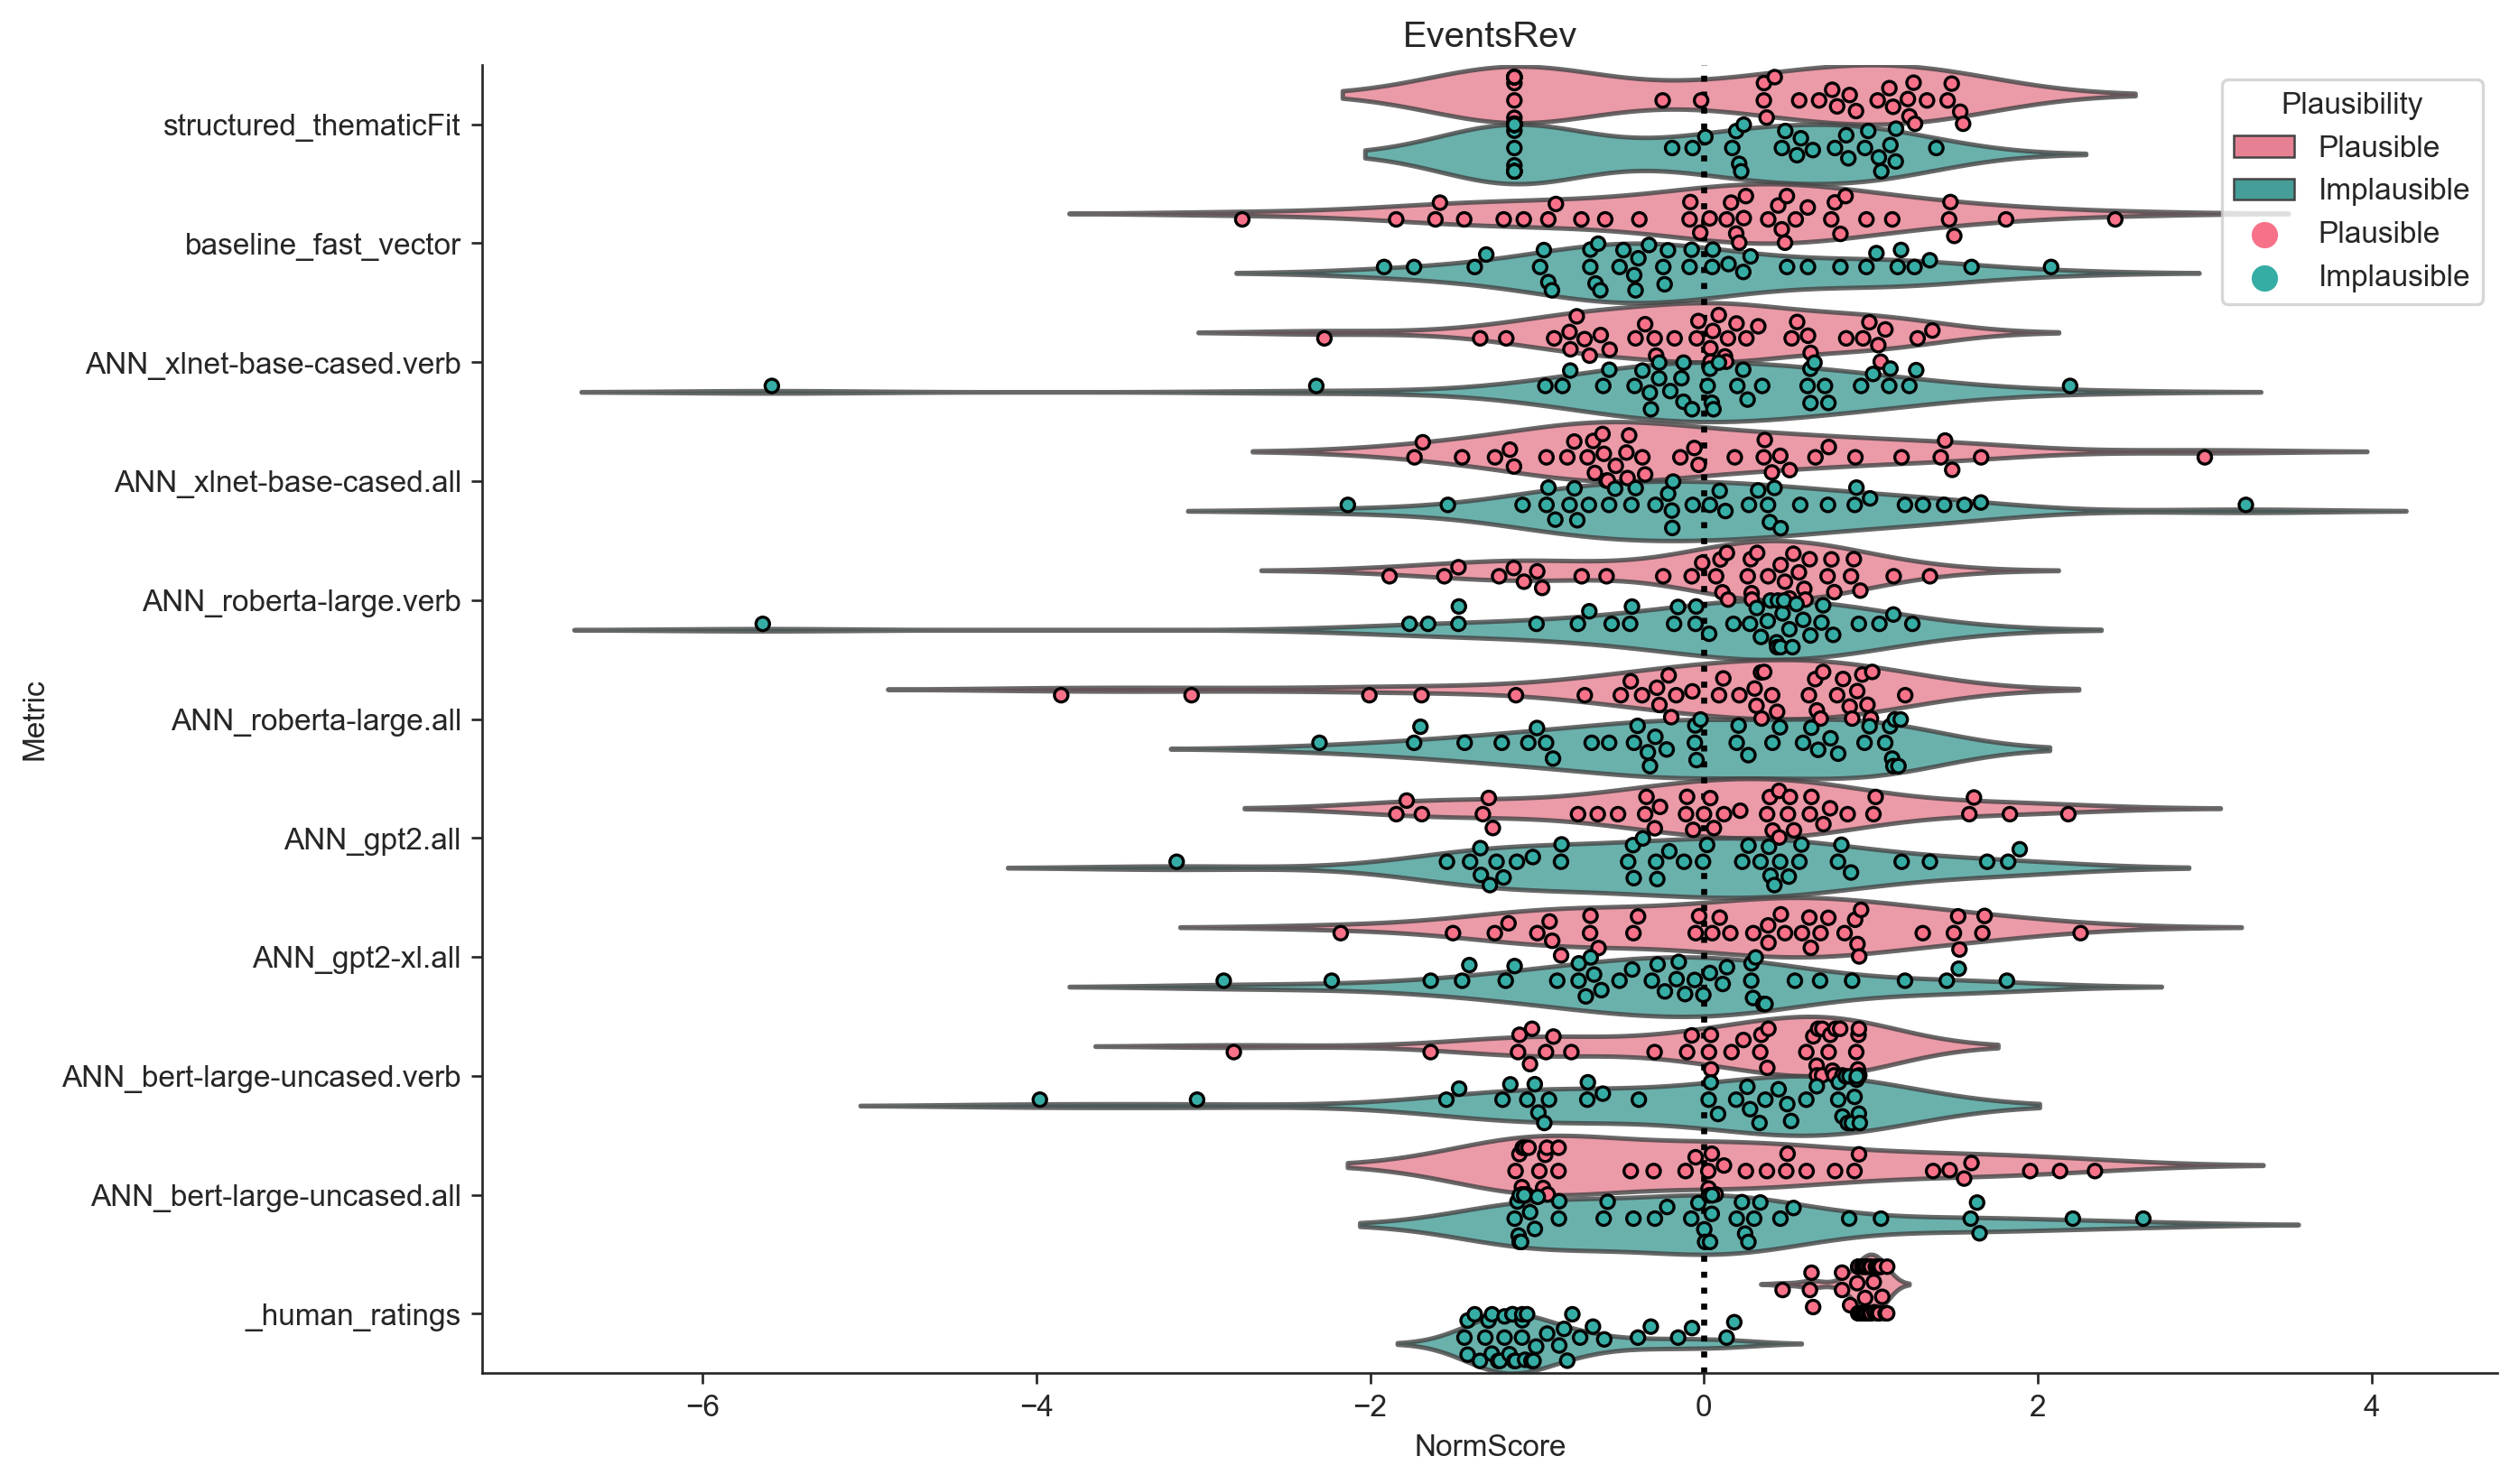

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

def violin_plot(results_df, study="EventsRev"):

    fig = figure(figsize=(12, 8), dpi=240)

    sns.set_style("ticks") #get rid of grid

    ax = sns.violinplot(x="NormScore", y="Metric", hue="Plausibility", scale='width',
                        width=1, data=results_df, inner=None, palette="husl")

    for violin in ax.collections:
        violin.set_alpha(0.8)

    ax = sns.swarmplot(x="NormScore", y="Metric", data=results_df, palette="husl",
                      hue='Plausibility', dodge=True, edgecolor="black", linewidth=1.0, s=4.5)

    sns.despine() #get rid of frame

    plt.axvline(0, color='black', linestyle=":",linewidth=2)
    plt.title(f"{study}")
    #plt.savefig('plots_EventsRev_carina/replication_binary-distribution.png',bbox_inches='tight', transparent=True, pad_inches=0)
    plt.show()
violin_plot(results_df)

## DTFIT interlude

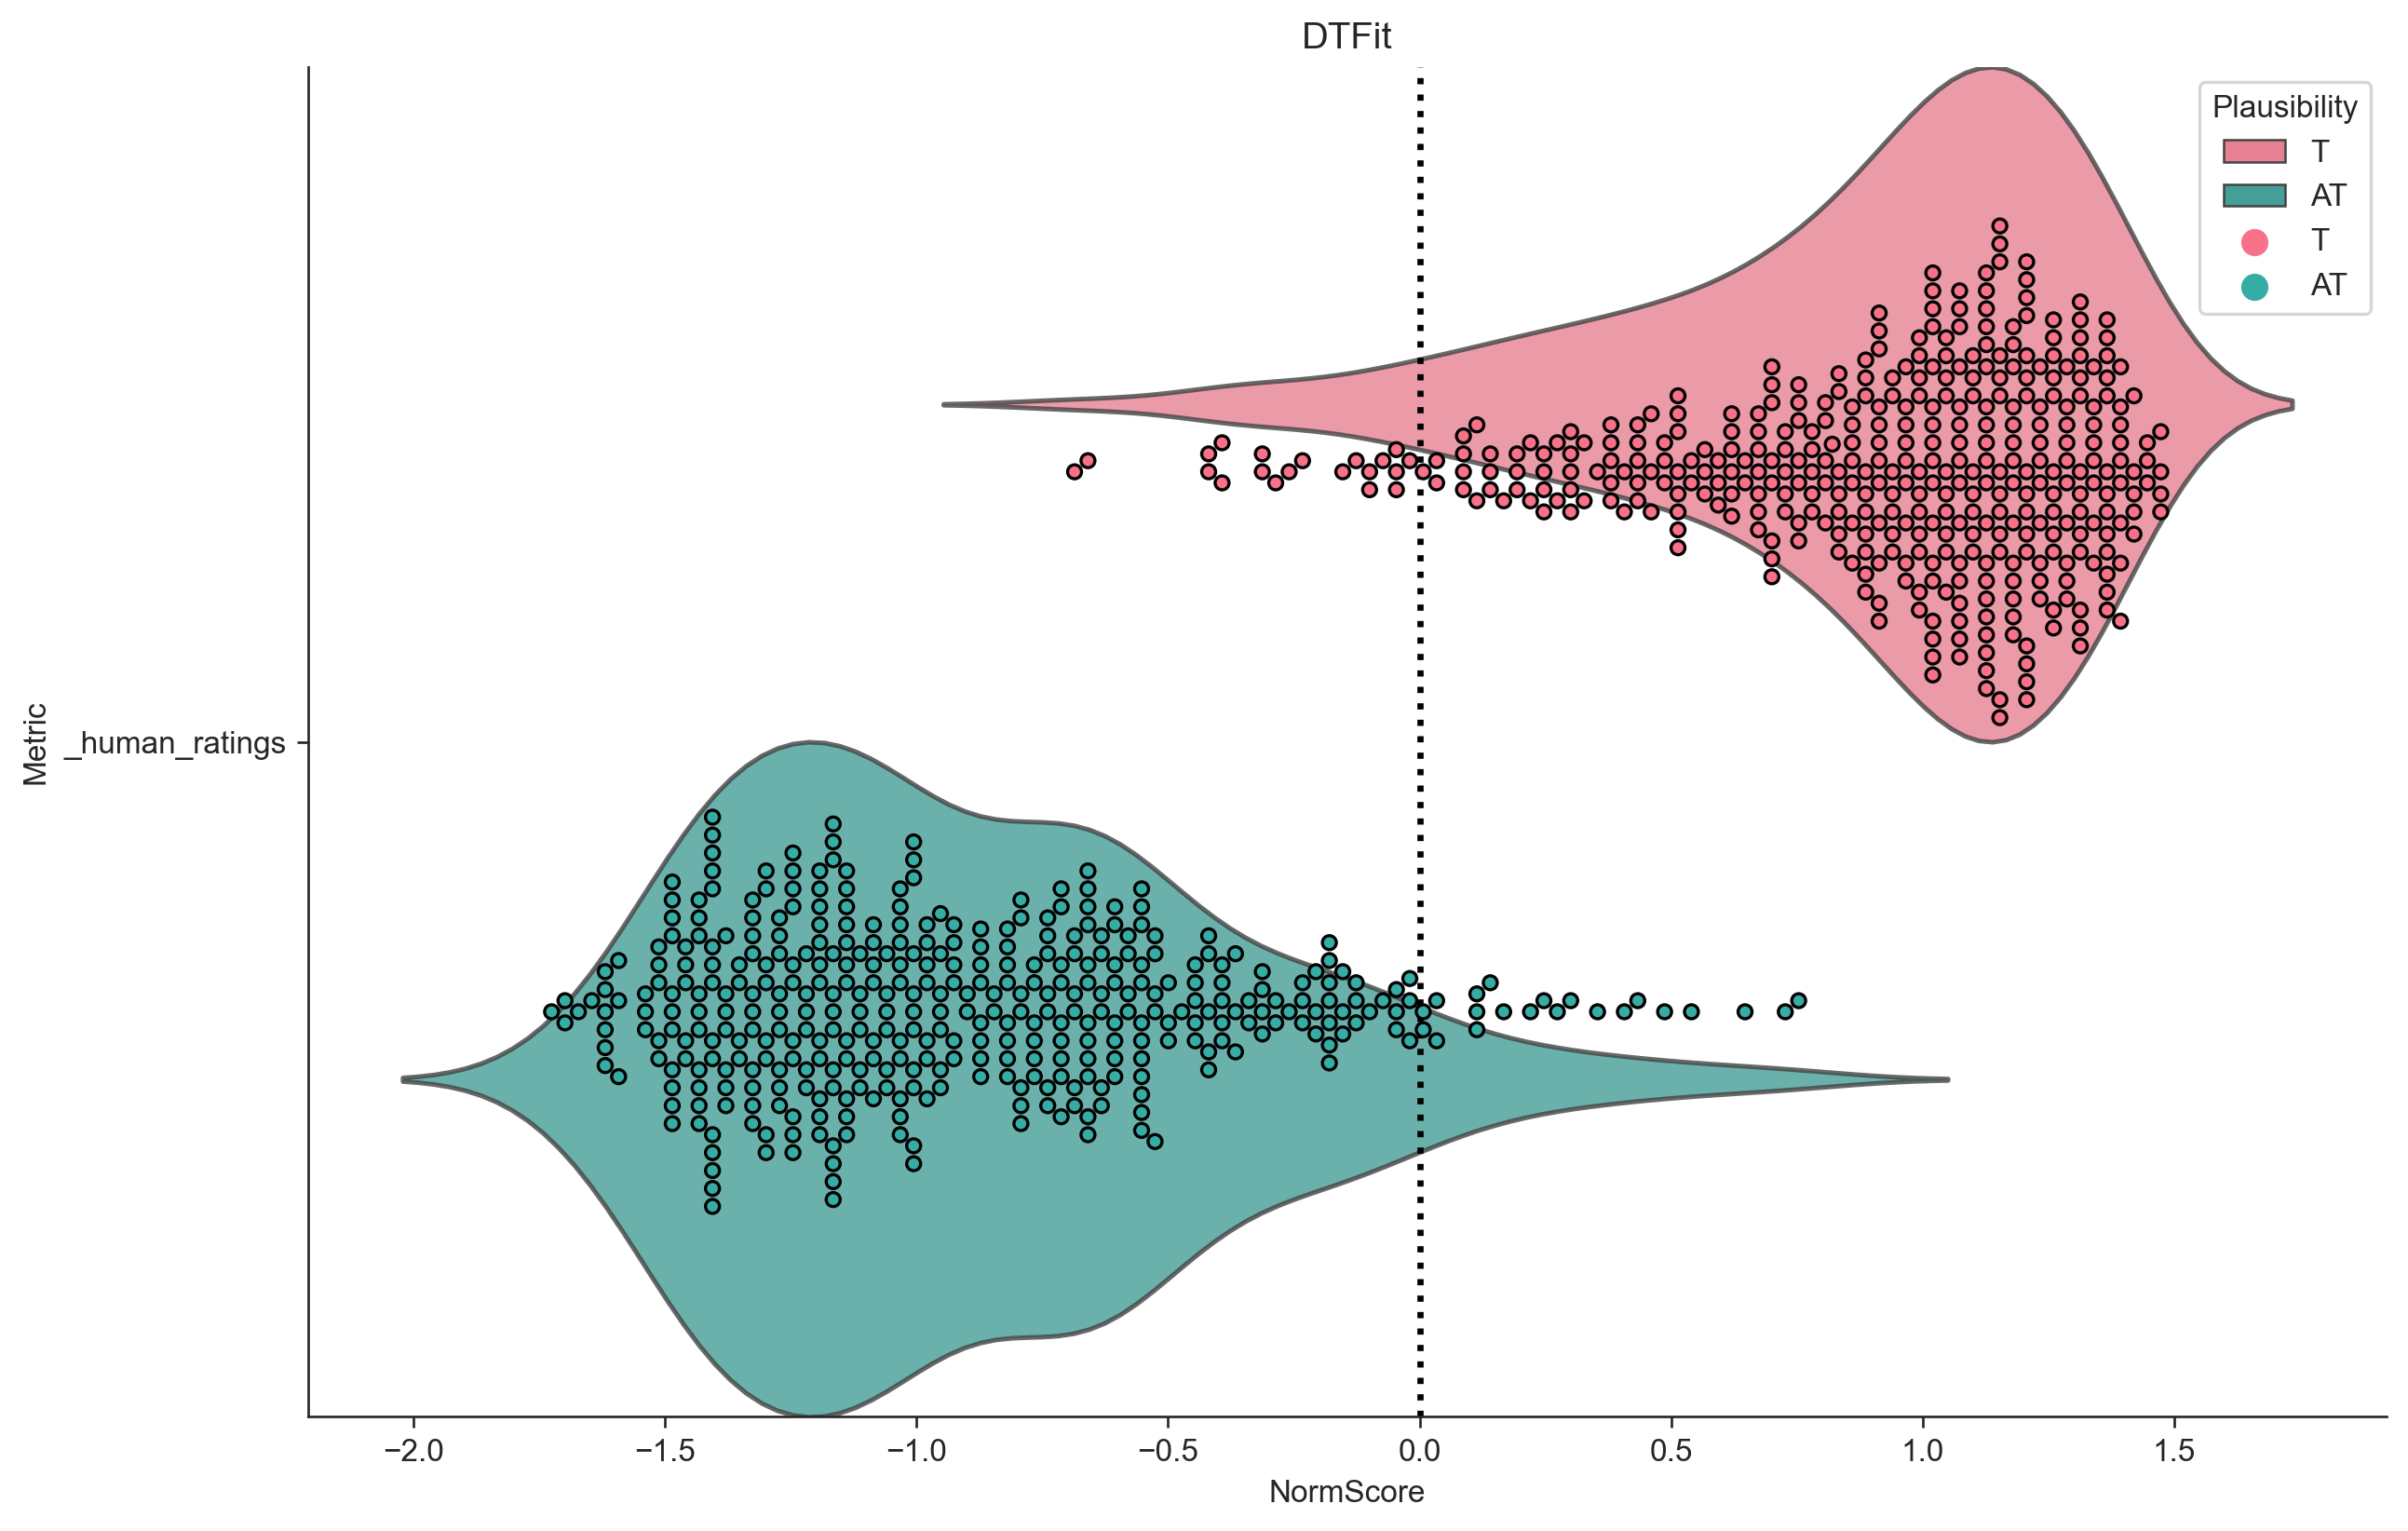

In [133]:
dtfit_human_df = dtfit_results_df.loc[dtfit_results_df["Metric"] == "_human_ratings"]
violin_plot(dtfit_human_df,study="DTFit")

/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 96.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 89.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 68.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


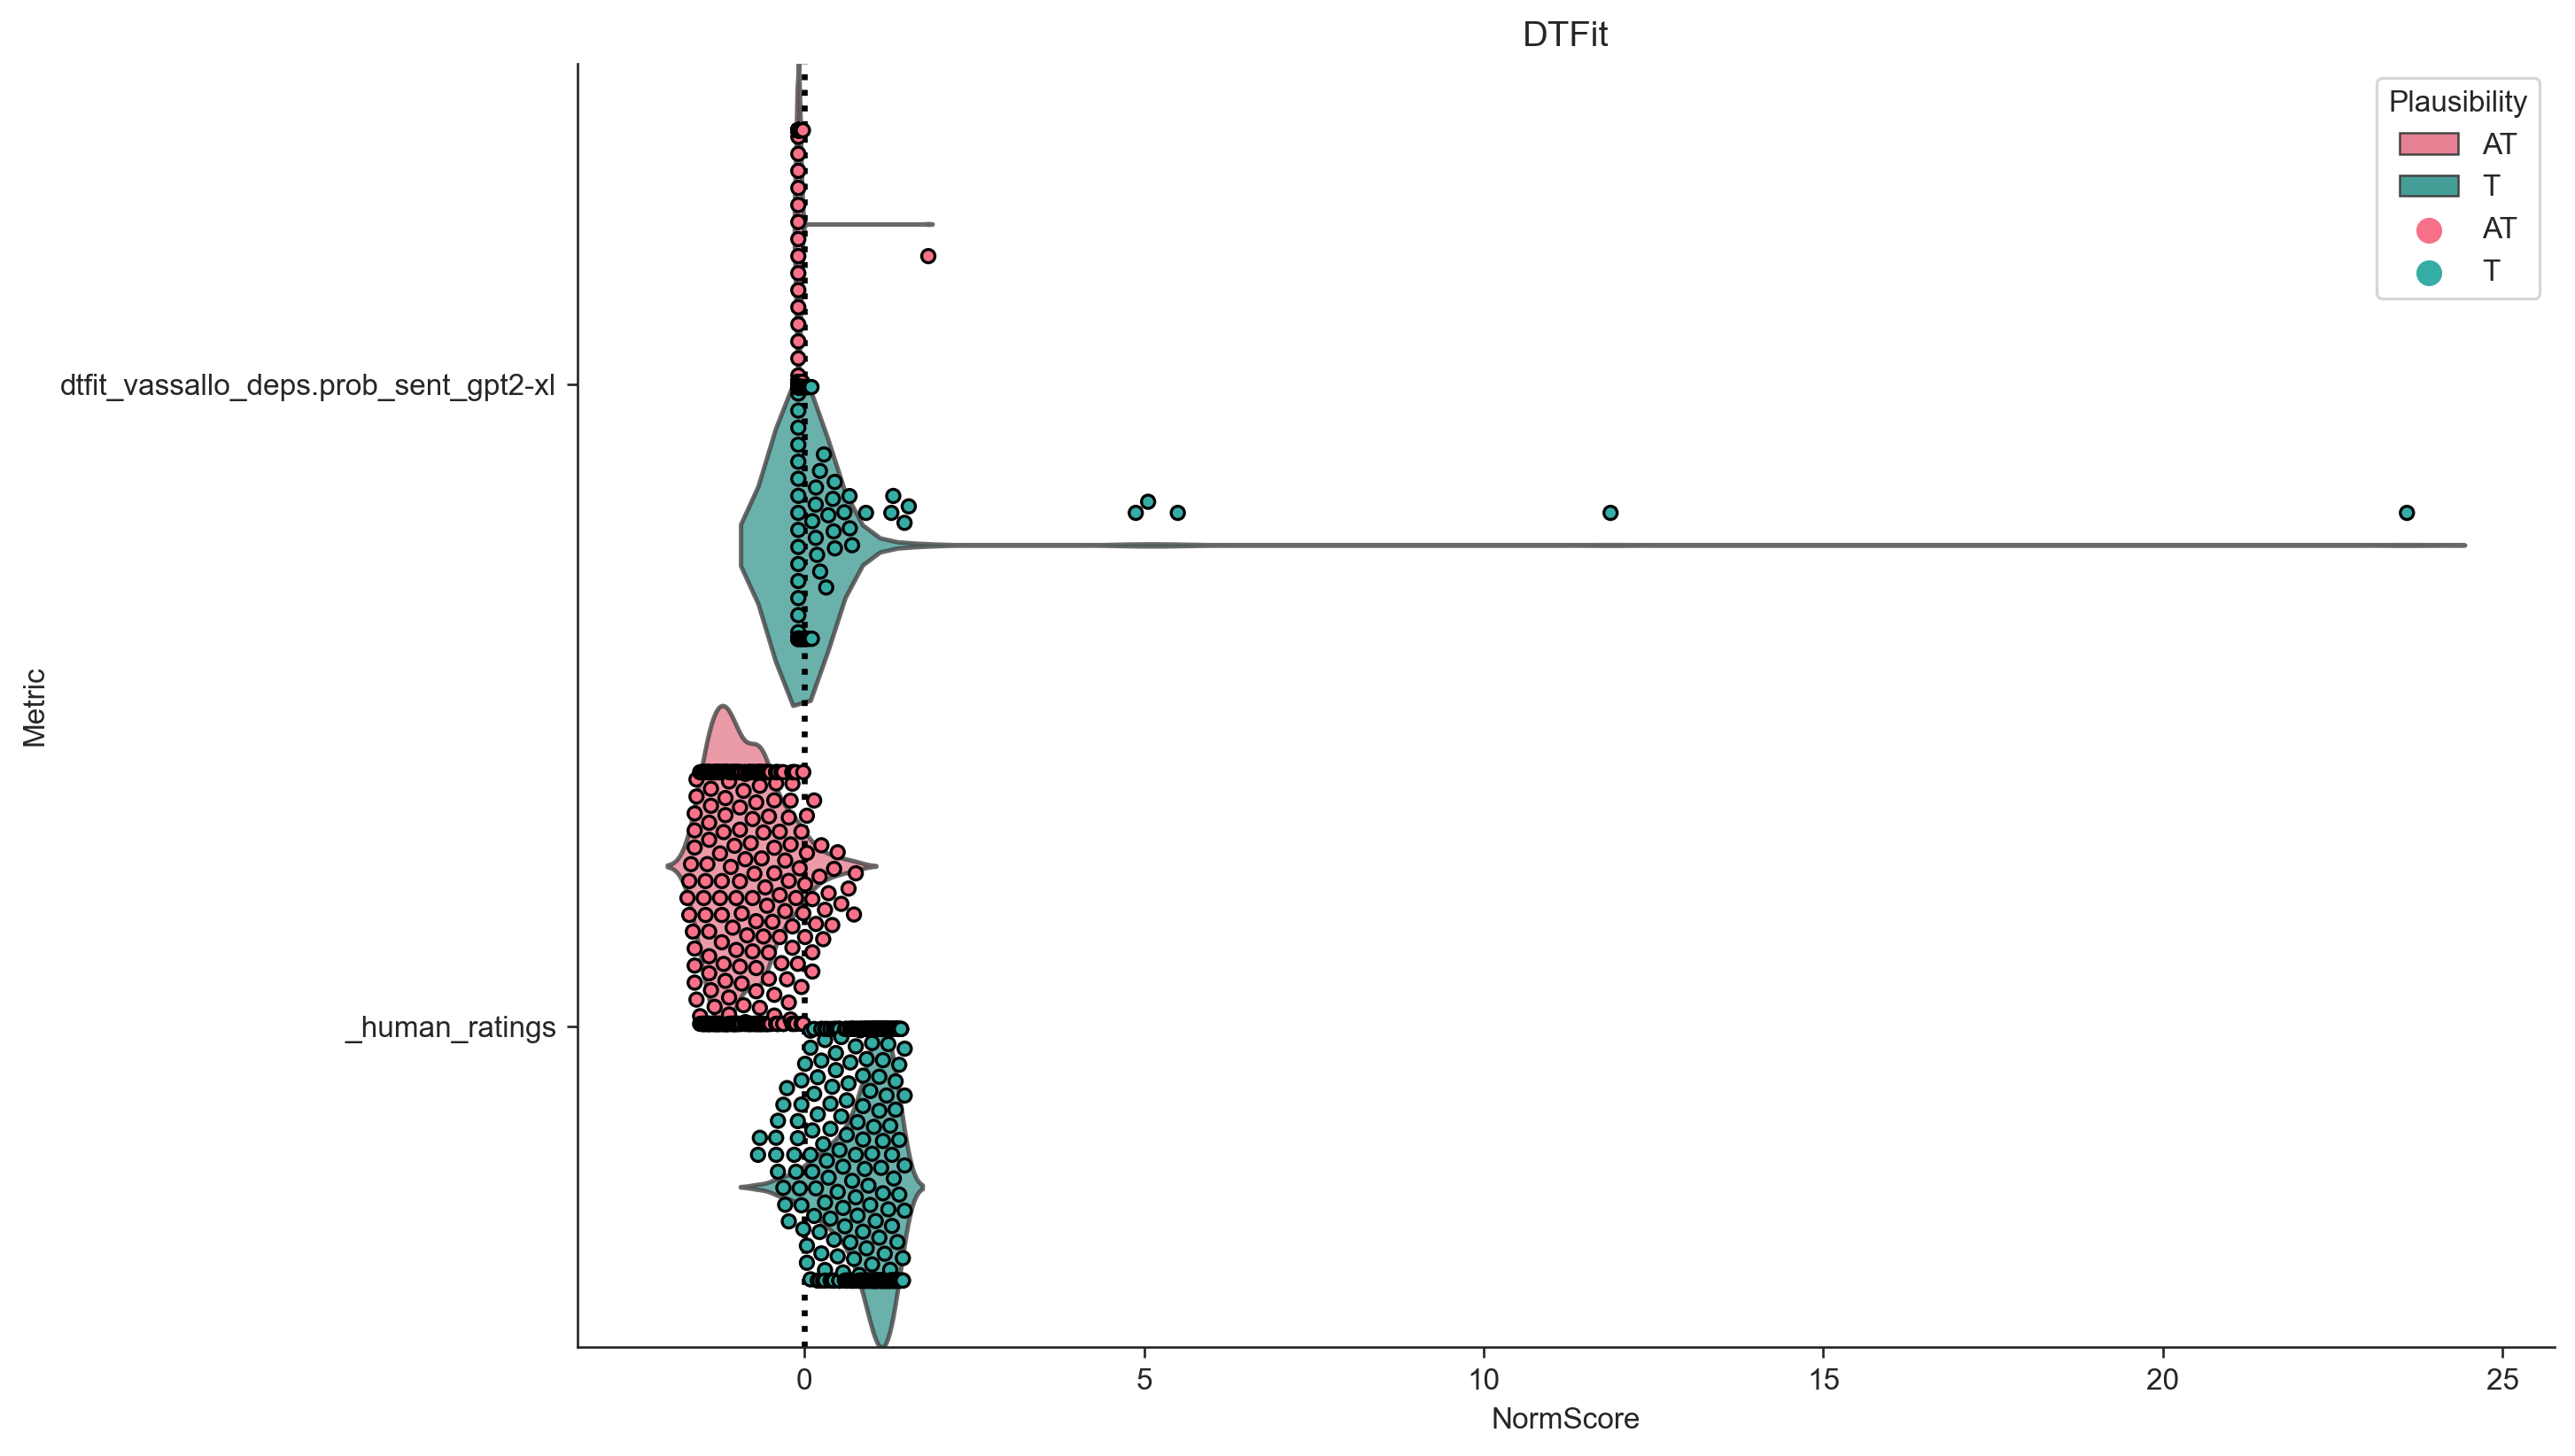

In [125]:
toplot = ["dtfit_vassallo_deps.prob_sent_gpt2-xl","_human_ratings"]

dtfit_plot_df = dtfit_results_df.loc[dtfit_results_df["Metric"].isin(toplot)]
dtfit_plot_df
violin_plot(dtfit_plot_df,study="DTFit")

In [126]:
print(ax.get_xticks(), ax.get_yticks())

[0.  0.2 0.4 0.6 0.8 1.  1.2] [ 0  1  2  3  4  5  6  7  8  9 10]


In [127]:
## Plot the scores
# import plotly.graph_objects as go

# fig = px.violin(results_df, y="Metric", x = "NormScore", color = "Plausibility", box=True, points="all", height=800)
# fig.show()

## Difference / Binary Choice

In [128]:
## Difference / Binary Choice

def binary_choice(dataframe):
    models_metrics = [elm.strip('.txt') for elm in custom_order]
    models_metrics[0] = 'structured_thematicFit' #for some reason the final t gets stripped
    print(models_metrics)
    
    accuracy_scores = []
    item_nrs = list(np.unique(dataframe['ItemNum']))
    for elm in models_metrics:
        curr_df = dataframe.loc[dataframe['Metric'] == elm]
        pl_scores = list(curr_df.loc[curr_df['Plausibility']=="Plausible"].Score)
        impl_scores = list(curr_df.loc[curr_df['Plausibility']=="Implausible"].Score)
        diff_scores = [a_i - b_i for a_i, b_i in zip(pl_scores, impl_scores)]
        
        if not models_metrics in ['structured_thematicFit', 'baseline_fast_vector']: #if ANN or human
            model_accuracy = sum([1 if elm >= 0 else 0 for elm in diff_scores])
        else:
            model_accuracy = sum([0 if elm >= 0 else 1 for elm in diff_scores]) #if cosine distance (smaller is better)
        
        accuracy_scores.append(model_accuracy/len(diff_scores))
        
    accuracy_df = pd.DataFrame({
        'model' : models_metrics,
        'accuracy' : accuracy_scores
    })
    return accuracy_df
        
accuracy_df = binary_choice(results_df)
accuracy_df

['structured_thematicFit', 'baseline_fast_vector', 'ANN_xlnet-base-cased.verb', 'ANN_xlnet-base-cased.all', 'ANN_roberta-large.verb', 'ANN_roberta-large.all', 'ANN_gpt2.all', 'ANN_gpt2-xl.all', 'ANN_bert-large-uncased.verb', 'ANN_bert-large-uncased.all', '_human_ratings']


,model,accuracy
0,structured_thematicFit,0.700
1,baseline_fast_vector,0.625
2,ANN_xlnet-base-cased.verb,0.450
3,ANN_xlnet-base-cased.all,0.350
4,ANN_roberta-large.verb,0.400
5,ANN_roberta-large.all,0.525
6,ANN_gpt2.all,0.625
7,ANN_gpt2-xl.all,0.850
8,ANN_bert-large-uncased.verb,0.525
9,ANN_bert-large-uncased.all,0.525


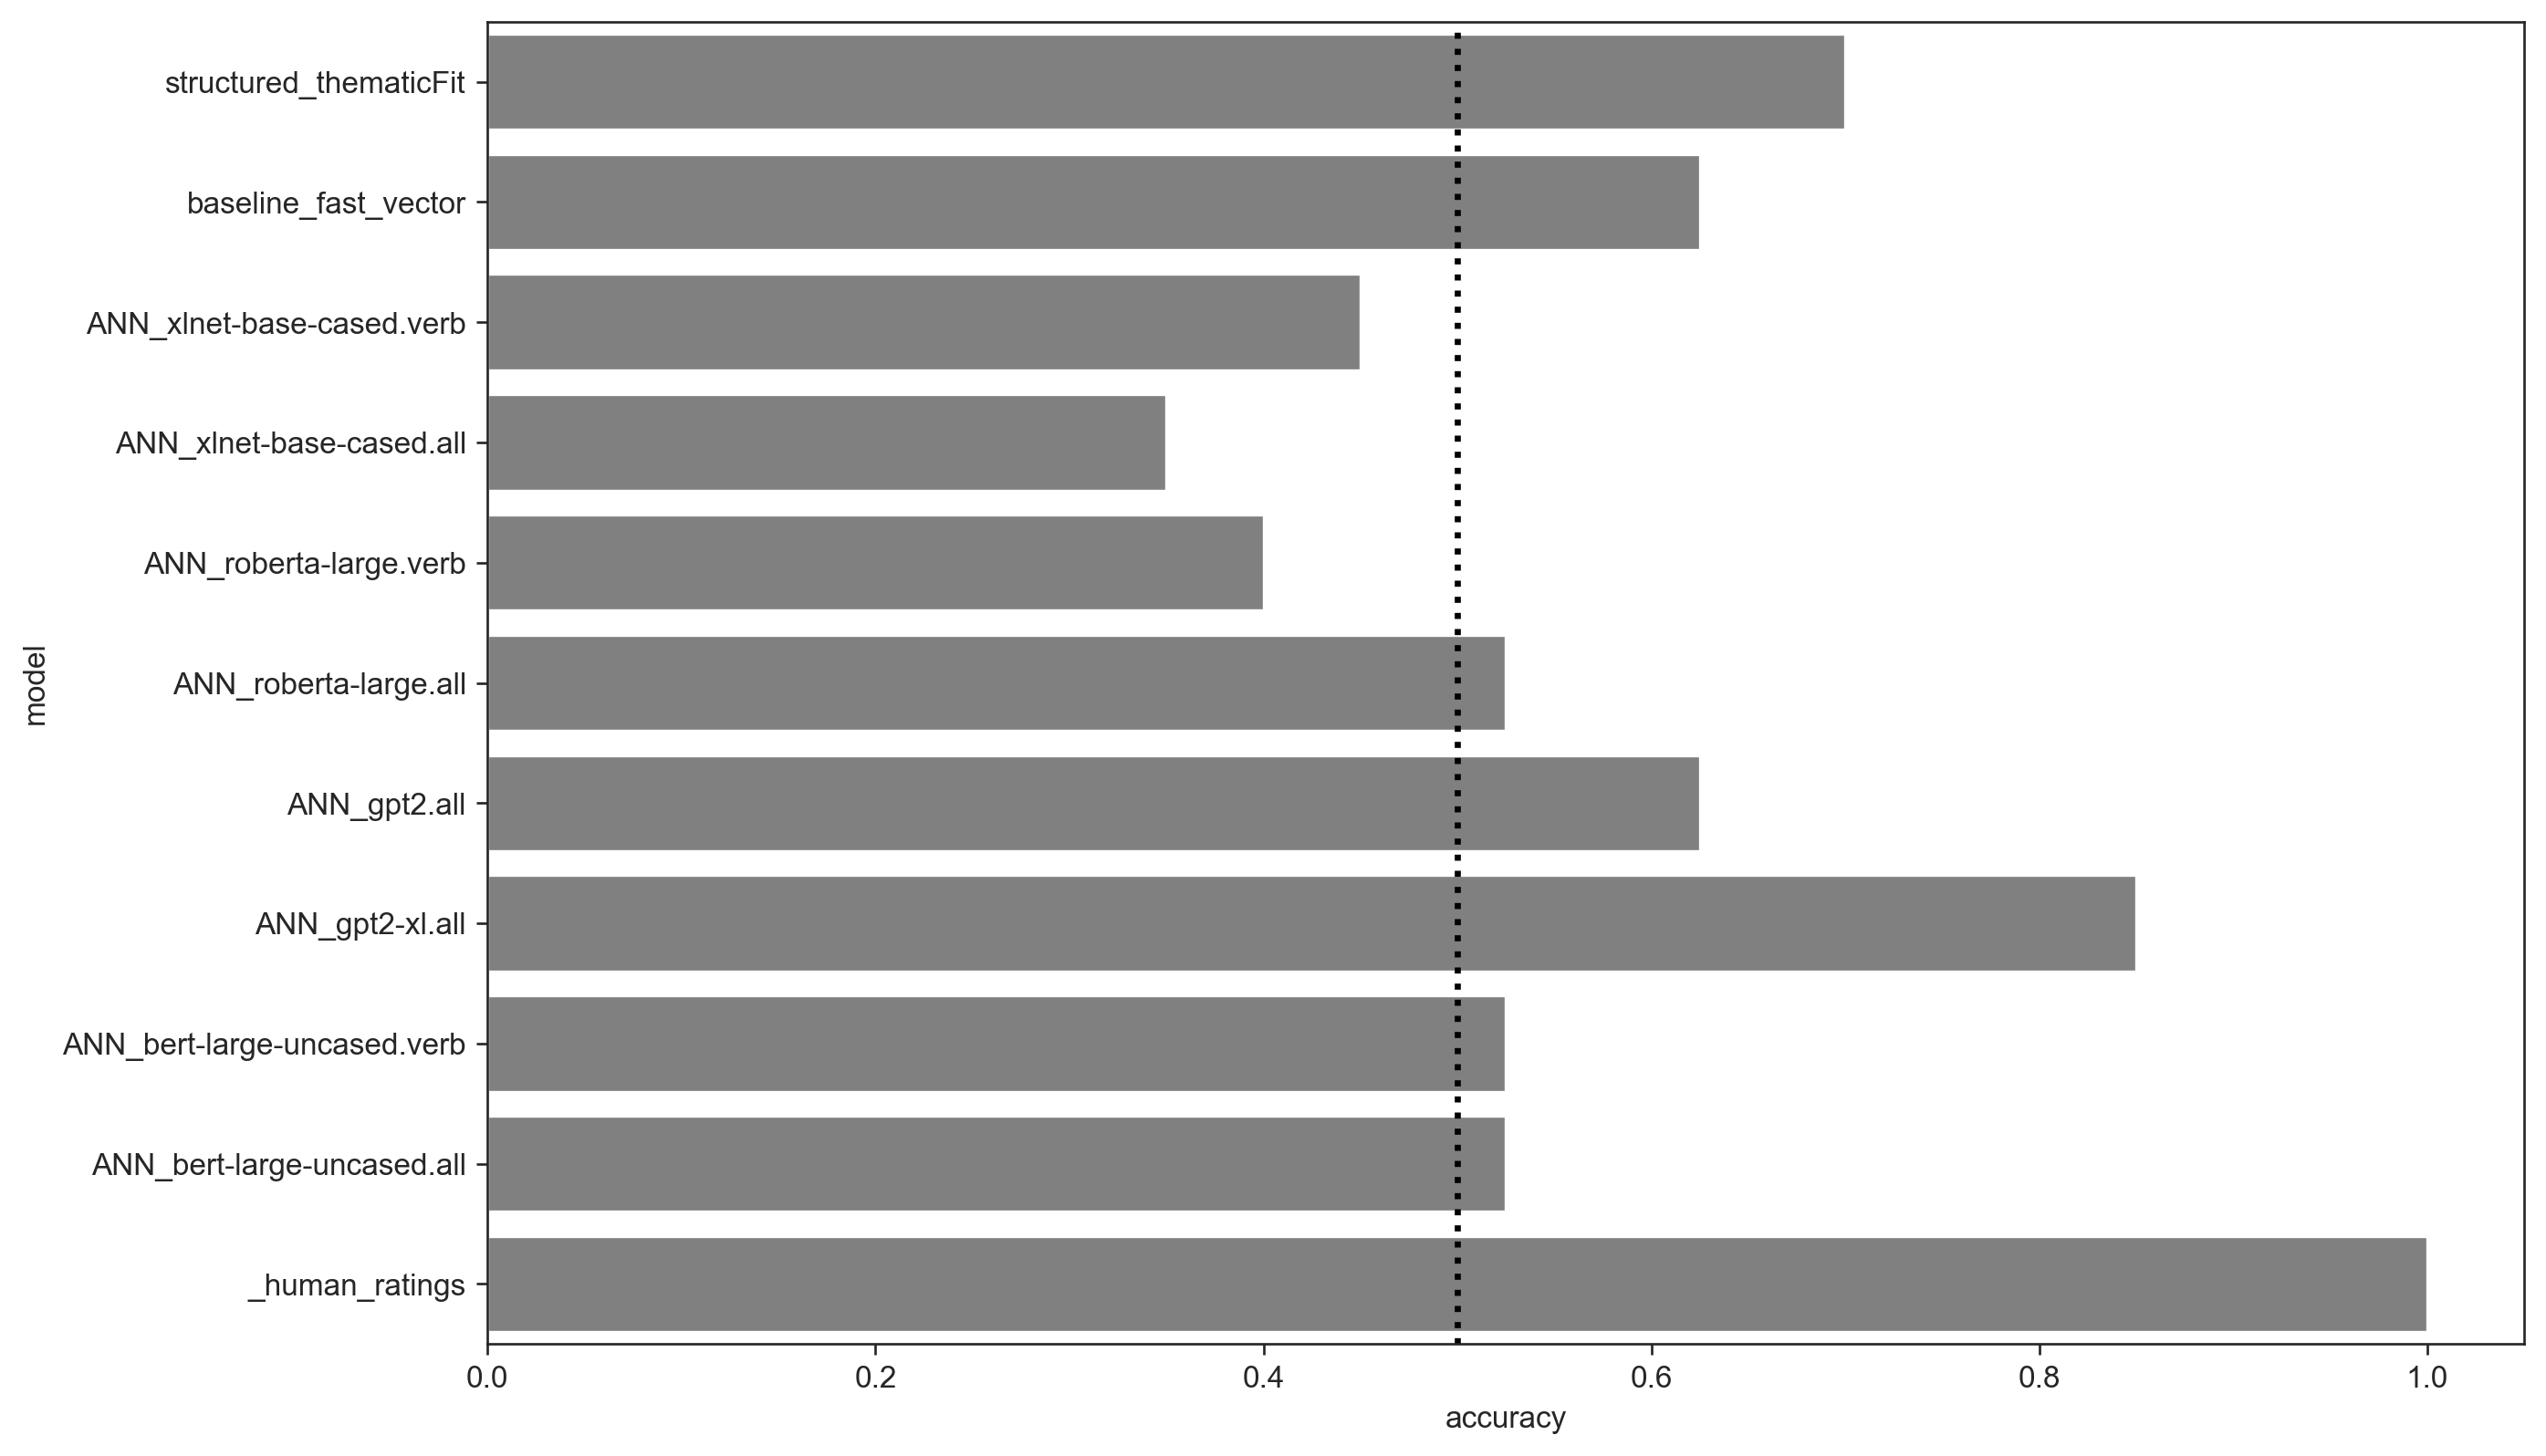

In [129]:
fig = figure(figsize=(12, 8), dpi=240)
ax = sns.barplot(x="accuracy", y="model", data=accuracy_df, color='gray')
plt.axvline(0.5, color='black', linestyle=":",linewidth=2)
#plt.savefig('plots_EventsRev_carina/replication_binary-choice.png',bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

## Item variation

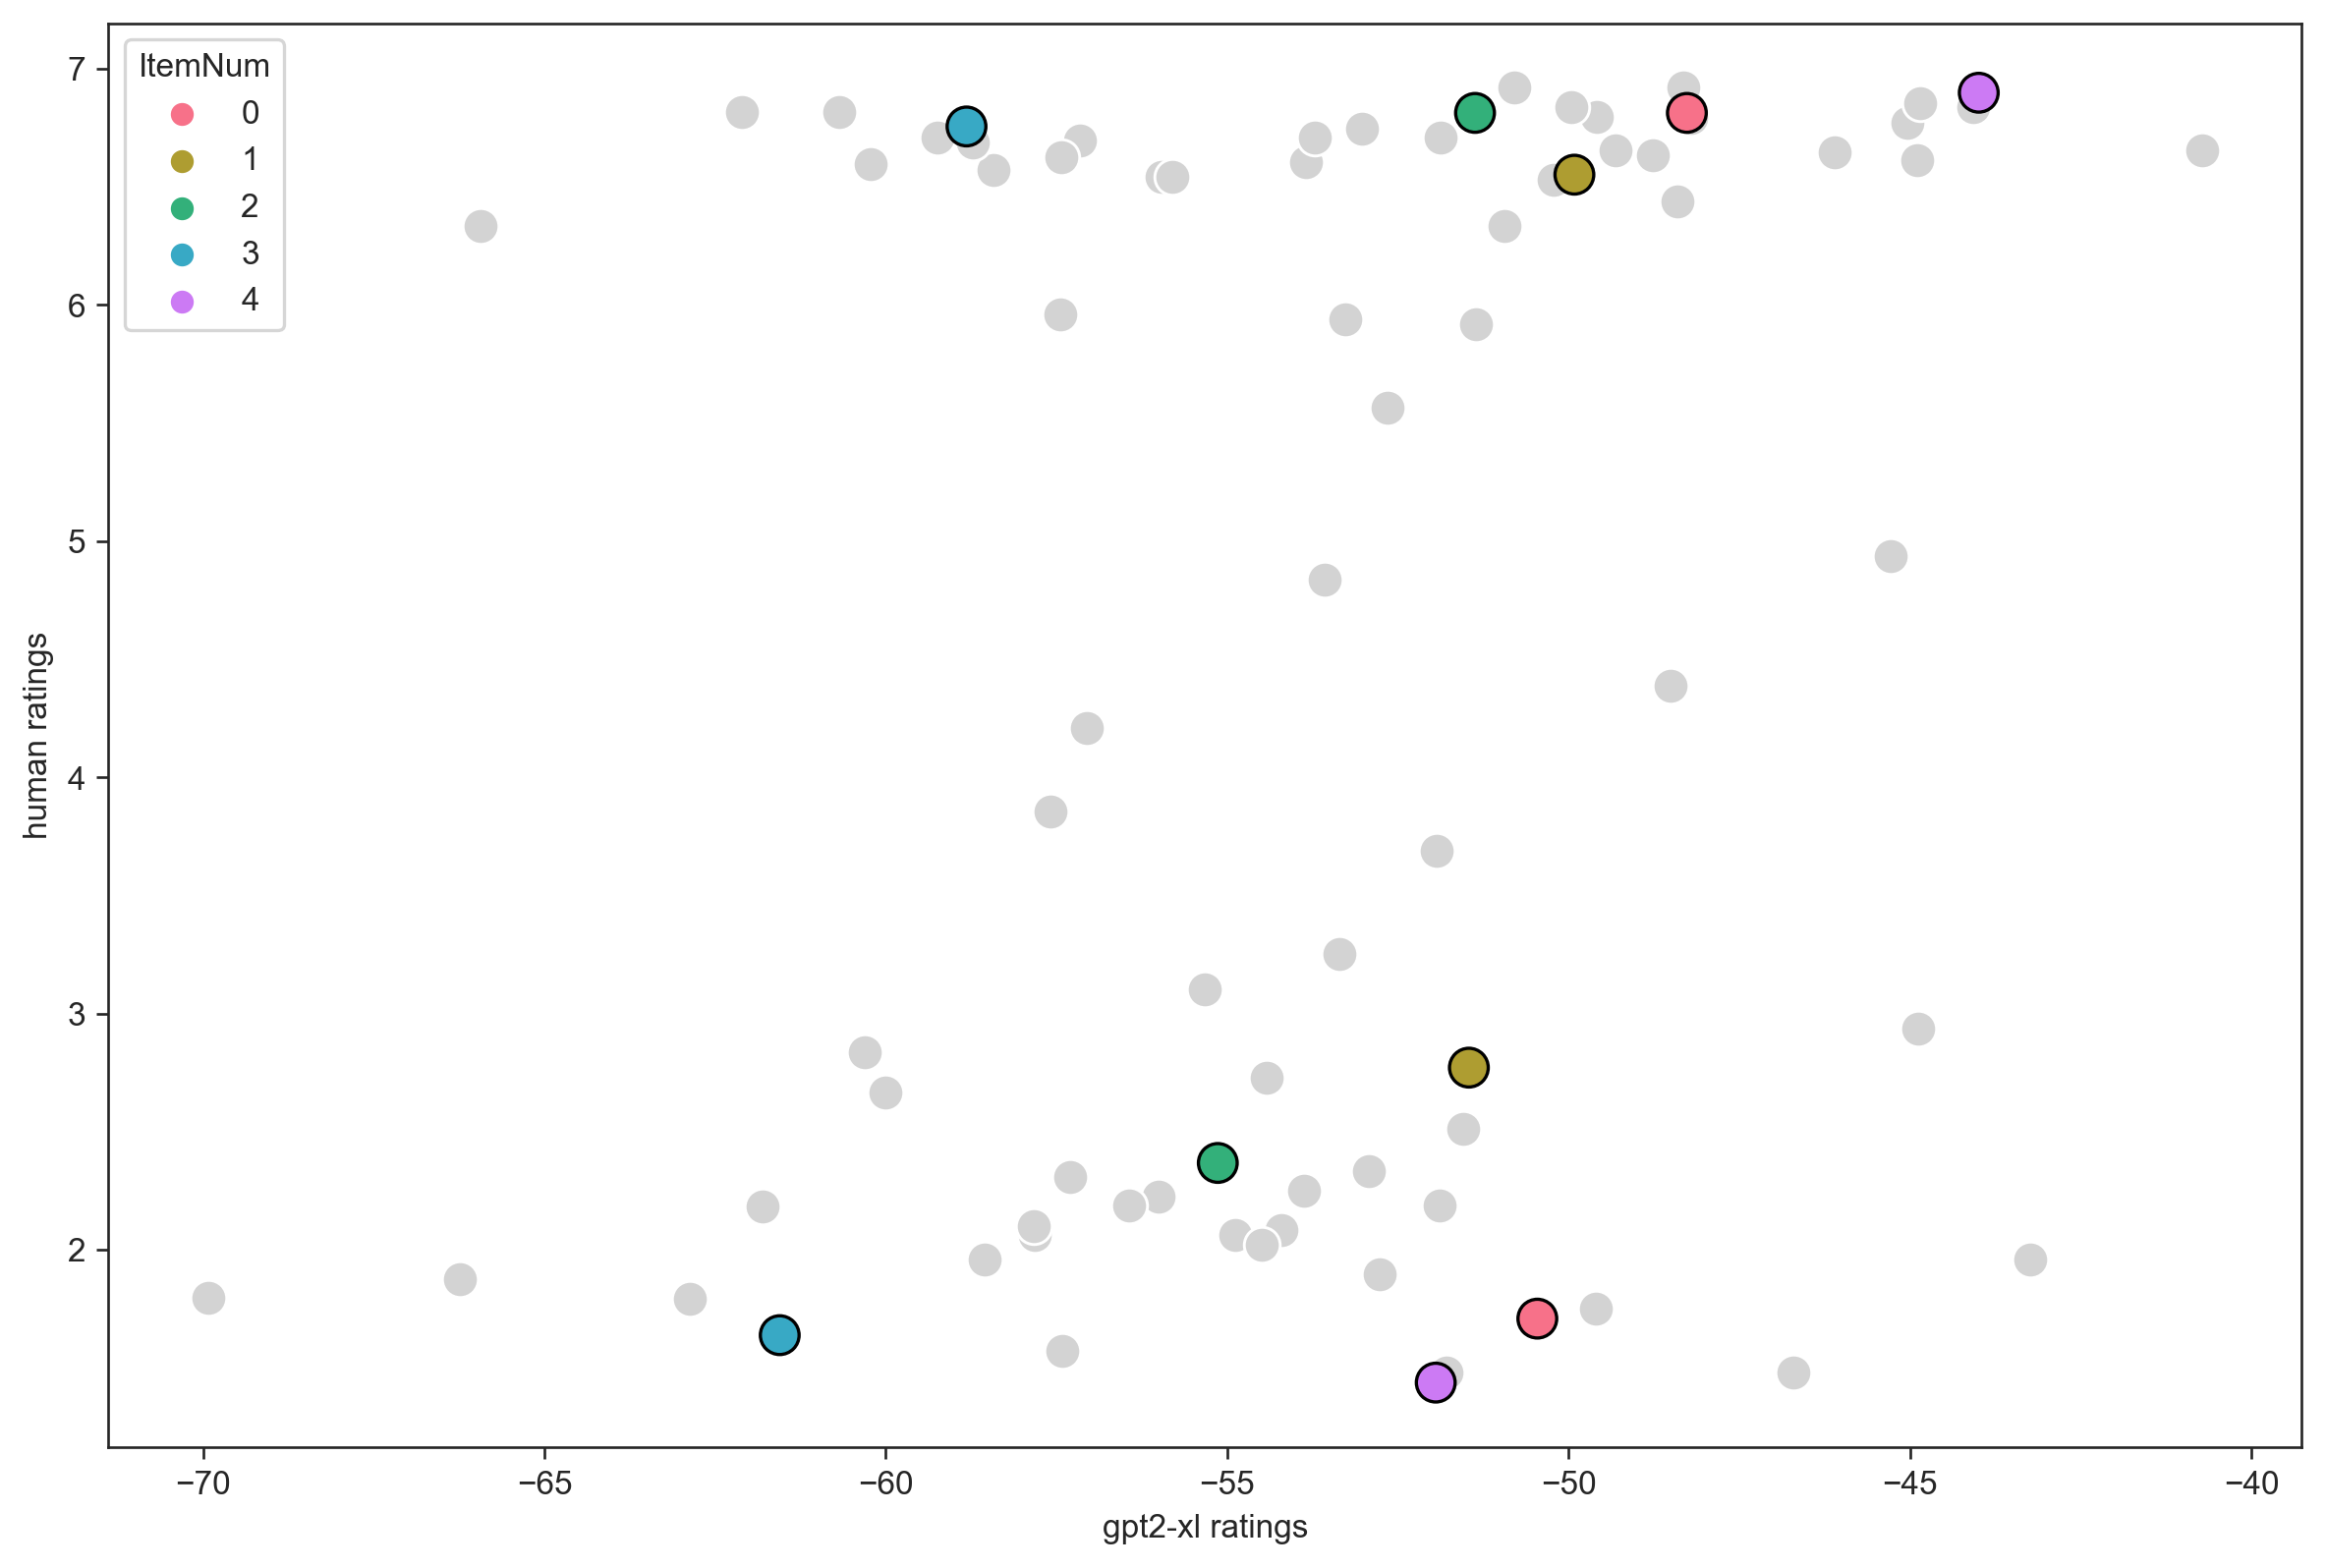

In [130]:
humans_df = results_df.loc[results_df['Metric'] == '_human_ratings']
sub_humans_df = humans_df.loc[humans_df['ItemNum'].isin([0,1,2,3,4])]

gpt2_df = results_df.loc[results_df['Metric'] == 'ANN_gpt2-xl.all']
gpt2_scores = list(gpt2_df['Score'])
sub_gpt2_df = gpt2_df.loc[gpt2_df['ItemNum'].isin([0,1,2,3,4])]

plot_df = humans_df.copy()
plot_df['gpt2_score'] = gpt2_scores

subplot_df = sub_humans_df.copy()
subplot_df['gpt2_score'] = gpt2_scores[:len(sub_humans_df)]
subplot_df

my_palette = sns.color_palette("husl", 5)

fig = figure(figsize=(12, 8), dpi=240)
sns.scatterplot(data=plot_df, x="gpt2_score", y="Score", color='lightgray', s=120)
sns.scatterplot(data=subplot_df, x="gpt2_score", y="Score", hue="ItemNum", palette=my_palette, s=140,
                edgecolor='black', linewidth=1)

plt.ylabel('human ratings')
plt.xlabel('gpt2-xl ratings')

#plt.savefig('plots_EventsRev_carina/replication_scatter-GPT2xl-humans.png',bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [131]:
ANNs = [elm for elm in list(np.unique(list(results_df['Metric']))) if 'ANN' in elm]
ANNs

['ANN_bert-large-uncased.all',
 'ANN_bert-large-uncased.verb',
 'ANN_gpt2-xl.all',
 'ANN_gpt2.all',
 'ANN_roberta-large.all',
 'ANN_roberta-large.verb',
 'ANN_xlnet-base-cased.all',
 'ANN_xlnet-base-cased.verb']

In [132]:
# ---
# title: "EventsComp analyses 2020-09-14"
# author: "Anna Ivanova"
# date: "9/14/2020"
# output: html_document
# ---

# ```{r setup, include=FALSE}
# knitr::opts_chunk$set(echo = TRUE)
# rm(list=ls()) 
# library(ggplot2)
# library(dplyr)
# #library(reshape)

# # custom function to read a datatable
# read_data <- function(directory, filename) {
#   d = read.delim(paste(directory, filename, sep='/'), 
#                  header=FALSE, sep='\t')
  
#   if (ncol(d)==4) {
#     d = d %>% rename(SentenceNum=V1, Sentence=V2, Plausibility=V3, Score=V4) %>%
#       mutate(ItemNum = SentenceNum %/% 2)
#   } else if (ncol(d)==3) {
#     d = d  %>%
#       rename(SentenceNum=V1, Sentence=V2, Score=V3) %>%
#       mutate(ItemNum = SentenceNum %/% 2) %>%
#       mutate(Plausibility = ifelse(SentenceNum%%2==0, 'Plausible', 'Implausible')) 
#   } else {
#     stop('unexpected number of columns in file')
#   }

#   d = d %>% 
#     mutate(Metric = substr(filename,1,nchar(filename)-4))
#   return(d)
# }
# ```

# # DTFit
# ## Load data
# ```{r read data, echo=FALSE}
# files = list.files(path='Dataset_DTFit', pattern="*.txt")
# dat = do.call(rbind, lapply(files, function(x) read_data('Dataset_DTFit', x)))

# # remove file with inconsistent formatting
# # and normalize scores
# dat = dat %>% 
#   filter(Metric!='fast_vector_sum_DTFit') %>%
#   #group_by(Metric) %>% mutate(NormScore =scale(Score, center=FALSE, scale=max(Score)))
#   group_by(Metric) %>% mutate(NormScore =scale(Score))
# ```


# ## Plot the scores

# ```{r plot scores, echo=FALSE}
# ggplot(data=dat)+
#     # stat_summary(mapping=aes(x=Metric, y=Score, fill=Typicality),
#     #            geom='bar', fun.y='mean', position='dodge',
#     #            color='black', width=0.5)+
#     geom_point(mapping = aes(x=Metric, y=NormScore, fill=Typicality),
#              shape=21, size=0.75, color='black',
#              position=position_jitterdodge(jitter.width=0.15, jitter.height=0, dodge.width=.5),
#              show.legend = TRUE)+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+coord_flip()
# ```

# ## Difference / Binary Choice

# ```{r pressure, echo=FALSE}
# dat.binchoice = dat %>% group_by(SentenceNum, Metric) %>%
#   summarise(ScoreDiff = Score[Typicality=="T"]-Score[Typicality=="AT"]) %>%
#   mutate(Accuracy = ifelse(ScoreDiff>0, 1, 0))
# ```

# ```{r}
# ggplot(data=dat.binchoice)+
#   stat_summary(mapping=aes(x=Metric, y=Accuracy),
#                geom='bar', fun.y='mean',
#                color='black', width=0.5)+
#   geom_hline(yintercept=0.5, linetype='dashed')+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+
#   labs(x=NULL, y='Accuracy')+
#   theme(axis.text.x=element_text(size=12), 
#         axis.title.y=element_text(size=14))+
#   coord_cartesian(ylim=c(0,1))+
#   coord_flip()
# ```

# # EventsRev
# ## Load data
# ```{r read data, echo=FALSE}
# dirname = 'model_data/EventsRev/'
# files = list.files(path=dirname, pattern="*.txt")
# dat = do.call(rbind, lapply(files, function(x) read_data(dirname, x)))

# dat$Score[grep("ANN", dat$Metric)] = log(dat$Score[grep("ANN", dat$Metric)])

# dat = dat %>% 
# #  filter(Metric!='fast_vector_sum_ev') %>%
#   #group_by(Metric) %>% mutate(NormScore =scale(Score, center=FALSE, scale=max(Score)))
#   #mutate(Score = ifelse(starts_with(as.character(Metric), 'ANN'), log(Score), Score)) %>%
#   group_by(Metric) %>% mutate(NormScore =scale(Score))
# ```

# ## Plot the scores

# ```{r plot scores, echo=FALSE}
# ggplot(data=dat)+
#     geom_violin(mapping = aes(x=Metric, y=NormScore, fill=Plausibility), 
#                 scale='width', width=0.6, alpha=0.5, position=position_dodge(width=0.6))+
#     geom_point(mapping = aes(x=Metric, y=NormScore, fill=Plausibility),
#              shape=21, size=0.75, color='black',
#              position=position_jitterdodge(jitter.width=0.15, jitter.height=0, dodge.width=.6),
#              show.legend = TRUE)+
#   labs(x='Model')+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+coord_flip()
# ggsave('plots/EventsRev/binary_distribution.png', width=16, height=12, units='cm')
# ```

# ## Difference / Binary Choice

# ```{r, echo=FALSE}
# dat.binchoice = dat %>% 
#   group_by(ItemNum, Metric) %>%
#   summarise(ScoreDiff = Score[Plausibility=="Plausible"]-Score[Plausibility=="Implausible"]) %>%
#   mutate(Accuracy = ifelse(ScoreDiff>=0, 1, 0))
# ```

# ```{r}
# #get confidence interval
# b = binom.test(20, 40, p=0.5, alternative='t')
# ci= b$conf.int

# #plot
# ggplot(data=dat.binchoice)+
#   geom_rect(xmin=-Inf, xmax=Inf, ymin=ci[1], ymax=ci[2], fill='gray90', alpha=0.04)+
#   stat_summary(mapping=aes(x=Metric, y=Accuracy),
#                geom='bar', fun.y='mean',
#                color='black', width=0.5)+
#   geom_hline(yintercept=0.5, linetype='dashed')+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+
#   labs(x='Model', y='Accuracy')+
#   theme(axis.text.x=element_text(size=12), 
#         axis.title.y=element_text(size=14))+
#   coord_cartesian(ylim=c(0,1))+
#   coord_flip()
# ggsave('plots/EventsRev/binary_choice.png', width=16, height=12, units='cm')
# ```

# ## Item variation

# ```{r}
# dat.wide = dat %>% 
#   dplyr::select(SentenceNum, Metric, Score) %>%
#   spread(Metric, Score) %>%
#   rename('human_ratings' = '_human_ratings',
#          'GPT2_XL' = 'ANN_gpt2-xl.all') %>%
#   mutate(ItemNum = as.character(SentenceNum%/%2))

# dat.wide.subset = dat.wide %>% filter(ItemNum %in% c(1,2,3,4,5))

# ggplot()+
#   geom_point(data=dat.wide, mapping=aes(x=GPT2_XL, y=human_ratings), color='gray', size=2)+
#   geom_point(data=dat.wide.subset, mapping=aes(x=GPT2_XL, y=human_ratings, fill=ItemNum),
#              size=3)+theme_classic()+
# ggsave('plots/EventsRev/scatter_GPT2xl_humans.png', width=16, height=12, units='cm')
# ```


# # SentAdapt
# ## Load data
# ```{r read data, echo=FALSE}
# files = list.files(path='Dataset_ev2_new', pattern="*.txt")
# dat = do.call(rbind, lapply(files, function(x) read_data('Dataset_ev2_new', x)))

# # remove file with inconsistent formatting
# # and normalize scores
# dat = dat %>% 
#   group_by(Metric) %>% mutate(NormScore =scale(Score))
# ```

# ## Plot the scores

# ```{r plot scores, echo=FALSE}
# ggplot(data=dat)+
#     geom_point(mapping = aes(x=Metric, y=NormScore, fill=Typicality),
#              shape=21, size=0.75, color='black',
#              position=position_jitterdodge(jitter.width=0.15, jitter.height=0, dodge.width=.5),
#              show.legend = TRUE)+
#     # stat_summary(mapping=aes(x=Metric, y=Score, fill=Typicality),
#     #            geom='bar', fun.y='mean', position='dodge',
#     #            color='black', width=0.5)+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+coord_flip()
# ```

# ## Difference / Binary Choice

# ```{r pressure, echo=FALSE}
# # exclude control sentences for now
# dat.binchoice = dat %>% 
#   filter(SentenceNum<549) %>%
#   group_by(SentenceNum, Metric) %>%
#   summarise(ScoreDiff = Score[Typicality=="Plausible"]-Score[Typicality=="Implausible"]) %>%
#   mutate(Accuracy = ifelse(ScoreDiff>0, 1, 0))
# ```

# ```{r}
# ggplot(data=dat.binchoice %>% filter())+
#   stat_summary(mapping=aes(x=Metric, y=Accuracy),
#                geom='bar', fun.y='mean',
#                color='black', width=0.5)+
#   geom_hline(yintercept=0.5, linetype='dashed')+
#   geom_hline(yintercept=0, linetype='dotted')+theme_classic()+
#   labs(x=NULL, y='Accuracy')+
#   theme(axis.text.x=element_text(size=12), 
#         axis.title.y=element_text(size=14))+
#   coord_cartesian(ylim=c(0,1))+
#   coord_flip()
# ```